<a href="https://colab.research.google.com/github/MRdvan/Pedestrian-Segmentation-with-U-Net/blob/master/CityScapes_segmentation_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
#from tensorflow import keras
#from keras.models import *
#from keras.layers import *
#from keras.optimizers import *
from keras import backend as keras
#from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.layers as tfl
import os
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dropout,UpSampling2D,Concatenate,Input,Softmax
from tensorflow.keras import Model
#from tensorflow.keras.callbacks import ModelCheckpoint
#from PIL import Image
#from os.path import splitext
from keras import backend as K
import albumentations as A
import glob


In [ ]:
import re

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    '''
    alist.sort(key=natural_keys) sorts in human order
    http://nedbatchelder.com/blog/200712/human_sorting.html
    (See Toothy's implementation in the comments)
    '''
    return [ atoi(c) for c in re.split(r'(\d+)', text) ]



In [ ]:
def pixel_counter(img):
  counter = 0
  for i in range(0,256):
        for j in range(0,256):
            if img[i,j] == 255:
                counter += 1
  print(counter)

In [ ]:

def load_images_from_folder(folder):
    images = []
    filenames = os.listdir(folder)
    filenames.sort(key=natural_keys)
    for filename in tqdm(filenames):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
        
    return images


### LOAD DATASET

In [ ]:
img_dataset = load_images_from_folder("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/new_image_dataset")
#mask_dataset = load_images_from_folder("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/new_mask_dataset")
mask1 = load_images_from_folder("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/person_masks_1")
mask2 = load_images_from_folder("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/person_masks_2")


100%|██████████| 3475/3475 [01:13<00:00, 47.32it/s] 


In [ ]:
input = load_images_from_folder("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/input")
mask = load_images_from_folder("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/mask")

100%|██████████| 4390/4390 [01:46<00:00, 41.20it/s] 


In [ ]:
mask = mask1 + mask2
print(len(mask))

6950


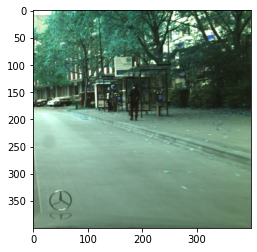

In [ ]:
plt.imshow(img_dataset[95])

In [ ]:
mask_1 = load_images_from_folder("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/mask_1")
mask_2 = load_images_from_folder("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/mask_2")

100%|██████████| 2172/2172 [01:08<00:00, 31.83it/s] 


In [ ]:
input = load_images_from_folder("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/input_dataset")
mask = load_images_from_folder("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/mask_dataset")

  1%|          | 43/4319 [00:08<13:32,  5.26it/s]

In [ ]:
#masks_1 = mask_dataset[:3475]
#masks_2 = mask_dataset[3475:]
images_1 = img_dataset[:3475]
images_2 = img_dataset[3475:]

In [ ]:
#print(len(masks_1))
#print(len(masks_2))
print(len(images_1))
print(len(images_2))

3475
3475


In [ ]:
#del mask_dataset
#del img_dataset
#del images_1
#del images_2
#del masks_1
#del masks_2
#del person_masks_1
del input_1,input_2,input

In [ ]:
#images_1 = load_images_from_folder("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/images_1")
#masks_1 = load_images_from_folder("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/masks_1")
#person_masks_1 = load_images_from_folder("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/person_masks_1")

100%|██████████| 3475/3475 [00:16<00:00, 205.46it/s]


In [ ]:
images_2 = load_images_from_folder("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/images_2")
#masks_2 = load_images_from_folder("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/masks_2")
person_masks_2 = load_images_from_folder("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/person_masks_2")

100%|██████████| 3475/3475 [00:20<00:00, 169.74it/s]


### NEW DATASET AUGMENTATION


In [ ]:
inputs = load_images_from_folder("/content/drive/MyDrive/penfuddataset/resized_images")
masks = load_images_from_folder("/content/drive/MyDrive/penfuddataset/resized_masks")

100%|██████████| 340/340 [00:06<00:00, 50.15it/s] 


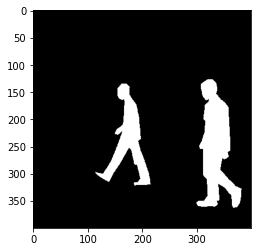

In [ ]:
plt.imshow(masks[0])

In [ ]:
from albumentations.augmentations.transforms import HorizontalFlip

original_height = 256
original_width = 256

def visualize(image):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(image)

augmented_dataset_masks = []
augmented_dataset = []

# mask = only_mask
# input = only_images

for i in range(0,len(mask)):
  input[i] = cv2.cvtColor(input[i], cv2.COLOR_BGR2RGB)
  transform = A.Compose([
      A.OneOf([
        A.RandomSizedCrop(min_max_height=(128, 128), height=original_height, width=original_width, p=0.5),
        A.PadIfNeeded(min_height=original_height, min_width=original_width, p=0.5)
    ],p=1),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.2),
    A.RandomBrightnessContrast(p=0.2),
    #A.RGBShift(p=0.2),
    ])
  
  transformed = transform(image=input[i], mask=mask[i])
  transformed_image = transformed['image']
  transformed_mask = transformed['mask']
  augmented_dataset.append(transformed_image)
  augmented_dataset_masks.append(transformed_mask)

In [ ]:
len(augmented_dataset)

4390

In [ ]:
mask_all = mask + augmented_dataset_masks
input_all = input + augmented_dataset

In [ ]:
mask=only_mask + augmented_dataset_masks
input=only_images + augmented_dataset

In [ ]:
len(input)


4390

In [ ]:
#saveDataset("/content/drive/MyDrive/penfuddataset/resized_images",augmented_dataset,"image",170)
saveDataset("/content/drive/MyDrive/penfuddataset/resized_masks",augmented_dataset_masks,"mask",170)

100%|██████████| 170/170 [00:01<00:00, 85.07it/s]


### FILTER PERSON FROM MASKS

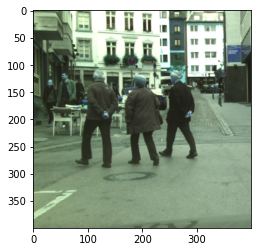

In [ ]:
plt.imshow(images_1[40])

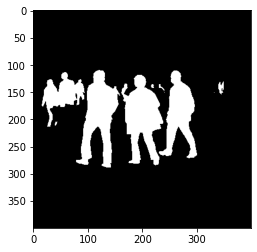

In [ ]:
plt.imshow(person_masks_1[40])

In [ ]:
img=masks_1[40]
print(img[200,200])

NameError: ignored

In [ ]:
def FilterPerson(mask_img):
  thr_img = np.zeros((400,400))

  for i in range(0,400):
    for j in range(0,400):
          if mask_img[i,j][0] == 93 and mask_img[i,j][1] == 93 and mask_img[i,j][2] == 93:
              thr_img[i,j]=255
          else:
              thr_img[i,j]=0
  return thr_img



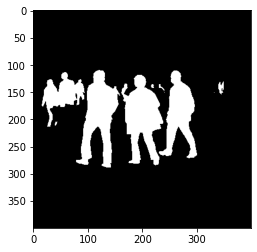

In [ ]:
person_img = person_masks_1[40]
plt.imshow(person_img,cmap="gray")
plt.show()

In [ ]:
person_img[200,200]

array([255, 255, 255], dtype=uint8)

In [ ]:
person_mask_dataset = []

def FilterPersonInList(masks):
  for mask in tqdm(masks):
      filtered_mask = FilterPerson(mask)
      person_mask_dataset.append(filtered_mask)
  return person_mask_dataset


In [ ]:
#person_mask_list = FilterPersonInList(masks_1)
person_mask_list = FilterPersonInList(masks_2)

100%|██████████| 3475/3475 [20:13<00:00,  2.86it/s]


In [ ]:
#saveDataset("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/person_masks_1",person_mask_list,"mask")
saveDataset("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/person_masks_2",person_mask_list,"mask")

100%|██████████| 3475/3475 [00:28<00:00, 121.53it/s]


In [ ]:
del person_mask_list

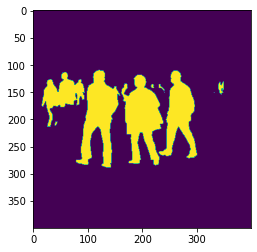

In [ ]:
plt.imshow(person_mask_dataset[40])


HEIGHT = 400
WIDTH = 400

resized_masks = [] 
for img in person_mask_dataset:
    resized = cv2.resize(img, (HEIGHT, WIDTH),interpolation = cv2.INTER_AREA)
    resized_masks.append(resized)

resized_imgs = [] 
for img in img_dataset:
    resized = cv2.resize(img, (HEIGHT, WIDTH),interpolation = cv2.INTER_AREA)
    resized_imgs.append(resized)


### DETECT BLACK AND PERSON IMAGES

In [ ]:
#del black_img_mask,black_input_image

In [ ]:
len(input_1)

2147

In [ ]:
len(mask_1)

2147

In [ ]:
for i in range(0,len(img_dataset)):
  #img_dataset[i] = cv2.resize(img_dataset[i], (256, 256),interpolation = cv2.INTER_AREA)
  #mask[i] = cv2.resize(mask[i], (256, 256),interpolation = cv2.INTER_AREA)
  img_dataset[i] = cv2.cvtColor(img_dataset[i], cv2.COLOR_BGR2RGB)
  mask[i] = cv2.cvtColor(mask[i], cv2.COLOR_RGB2GRAY)

In [ ]:
hist = []
for i in range(len(mask)):
   hist.append(cv2.calcHist([mask[i]],[0],None,[256],[0,256]))

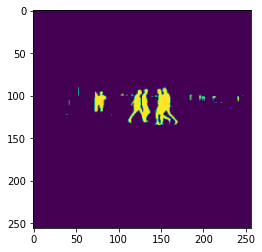

In [ ]:
plt.imshow(mask[30])

In [ ]:
only_images = []
only_mask = []
for i in range(len(mask)):
  if hist[i][255] > 200:
    only_images.append(img_dataset[i])
    only_mask.append(mask[i])


In [ ]:
len(only_mask)

2195

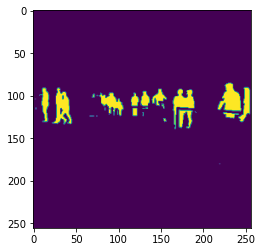

In [ ]:
plt.imshow(only_mask[33])

In [ ]:
#black_img_mask = []
#black_input_image = []input_img_list,

def isBlack(input_img_list,mask_img_list):
  hasPerson = False
  
  if len(input_img_list) != len(mask_img_list): 
     print("HATA:: INPUT_IMAGE_LIST ILE MASK_IMG_LIST SIZE LARI FARKLI!!! \n")
     return
  
  list_range = len(mask_img_list)
  index=0
  while index<list_range:
    mask_img = mask_img_list[index]
    hasPerson = False
    counter = 0
    for i in range(0,256):
          for j in range(0,256):
              if mask_img[i,j] ==255:
                  counter += 1
    if counter > 1000:
        hasPerson = True
    if hasPerson == False:
        mask_img_list.pop(index)
        input_img_list.pop(index)
        list_range = len(mask_img_list)
    index+=1

  #if len(black_img_mask) != len(black_input_image): 
  #  print("HATA:: BLACK_INPUT_IMG ILE BLACK_IMG_MASK SIZE LARI FARKLI!!! \n")
  #  return

  #print("There are "+ str(len(black_img_mask)) + "black masks and input image founded\n" )

In [ ]:
isBlack(input,mask)

In [ ]:
i = 0
for img in mask:
  print(i)
  pixel_counter(img)
  i+=1

0
1059
1
0
2
89
3
1087
4
2312
5
1321
6
1256
7
1324
8


KeyboardInterrupt: ignored

In [ ]:
plt.imshow(input[2])

In [ ]:
len(images_2)

2172

In [ ]:
len(person_masks_2)

2172

In [ ]:
len(images_2)

1737

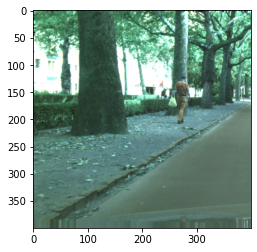

In [ ]:
plt.imshow(images_2[40])

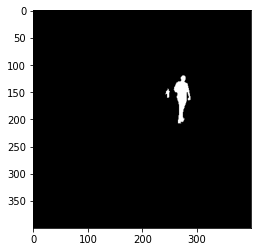

In [ ]:
plt.imshow(person_masks_2[40])

In [ ]:
del images_1
del person_masks_1

### SAVE DATASET

In [ ]:
def saveDataset(path,dataset,name,idx=0):
    for i in tqdm(range(len(dataset))):
        #dataset[i] = cv2.cvtColor(dataset[i],cv2.COLOR_BGR2RGB)
        cv2.imwrite(os.path.join(path , str(name)+str(idx)+'.png'), dataset[i])
        idx+=1




In [ ]:
saveDataset("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/input_2",images_2,"image",2147)
saveDataset("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/mask_2",person_masks_2,"mask",2147)

100%|██████████| 2172/2172 [00:16<00:00, 131.00it/s]


In [ ]:
saveDataset("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/images_2",only_person_images_2,"image",2412)
#saveDataset("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/masks_2",masks_2,"mask",0)


100%|██████████| 2409/2409 [01:03<00:00, 37.64it/s]


In [ ]:
#saveDataset("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/input_dataset",input,"image",0)
#saveDataset("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/mask_dataset",mask,"mask",0)


100%|██████████| 4319/4319 [00:33<00:00, 129.38it/s]


In [ ]:
saveDataset("/content/sample_data/image_dataset/",img_dataset,"image")

In [ ]:
len(masks_2)

5884

In [ ]:
masks_2 = masks_2[:3475]

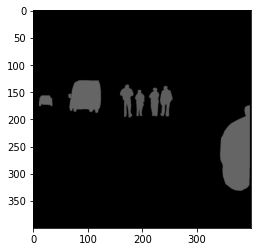

In [ ]:
plt.imshow(masks_2[0])

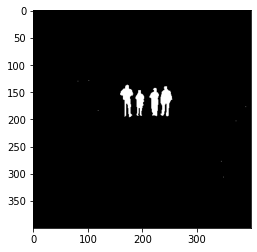

In [ ]:
plt.imshow(person_masks_2[0])

In [ ]:
#saveDataset("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/masks_1",masks_1,"mask",0)
saveDataset("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/images_1",images_1,"image",0)

100%|██████████| 3475/3475 [01:25<00:00, 40.79it/s]


In [ ]:
len(images_2)

3475

In [ ]:
#saveDataset("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/person_maskeler_2",person_masks_2,"mask",3475)
#saveDataset("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/maskeler_2",masks_2,"mask",3475)
saveDataset("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/images_2",images_2,"image",3475)

100%|██████████| 3475/3475 [00:28<00:00, 122.74it/s]


In [ ]:
#del img_dataset
del images_2
#del mask_dataset
#del person_mask_dataset

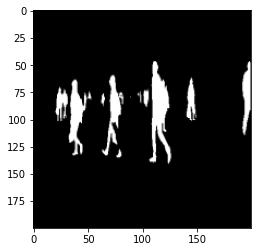

In [ ]:
plt.imshow(resized_masks[3362])

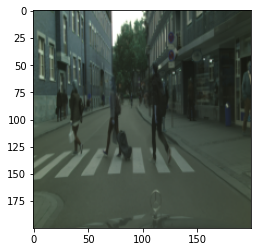

In [ ]:
plt.imshow(resized_imgs[3362])

In [ ]:
print(resized_imgs[0].shape)
print(resized_masks[0].shape)

(200, 200, 3)
(200, 200, 3)


In [ ]:
for i in range(len(mask_1)):
  mask_1[i] = cv2.cvtColor(mask_1[i], cv2.COLOR_RGB2GRAY)
  #resized_masks[i] = np.expand_dims(resized_masks[i],axis=2)

In [ ]:
input_1 = np.array(input_1).reshape(len(input_1),400,400,3)
mask_1 = np.array(mask_1).reshape(len(mask_1),400,400)

In [ ]:
print(type(input_1[0]))
print(type(mask_1))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
print(input_1.shape)
print(mask_1.shape)

(2159, 400, 400, 3)
(2159, 400, 400)


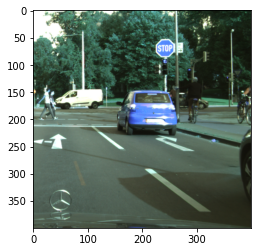

In [ ]:
plt.imshow(input[4310])

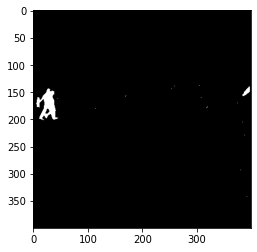

In [ ]:
plt.imshow(mask[4310])

### MODEL BUILDING

In [ ]:
#REGULARİZASYON OLMAYAN MODEL
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

filter_scale = 5/4

def build_model(inputsize=(256,256,3),classes=None):
    inputs = tf.keras.Input(shape=(inputsize))

    conv = tfl.Conv2D(32*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv1')(inputs)
    x=tfl.BatchNormalization()(conv)
    x=tfl.LeakyReLU()(x)
    x1 = tfl.Conv2D(32*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv2')(x)
    x=tfl.BatchNormalization()(x1)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool1')(x)

    x = tfl.Conv2D(64*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv3')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x2 = tfl.Conv2D(64*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv4')(x)
    x=tfl.BatchNormalization()(x2)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), name='MaxPool2')(x)

    x = tfl.Conv2D(128*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv5')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x3 = tfl.Conv2D(128*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv6')(x)
    x=tfl.BatchNormalization()(x3)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool3')(x)

    
    x = tfl.Conv2D(256*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv7')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(256*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv8')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(256*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv9')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    
    x = tfl.Conv2DTranspose(128*filter_scale, (3, 3), strides=2, padding="same")(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x3], axis=3)
    
    x = tfl.Conv2D(128*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv10')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(128*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv11')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2DTranspose(64*filter_scale, (3, 3), strides=2, padding="same")(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x2], axis=3)

    x = tfl.Conv2D(64*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv12')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(64*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv13')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    
    x = tfl.Conv2DTranspose(32*filter_scale, (3, 3), strides=2, padding="same")(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x1], axis=3)

    x = tfl.Conv2D(32*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv14')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(32*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', name='Conv15')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    
    outputs = tfl.Conv2D(classes, (1, 1), padding="same", activation='sigmoid', name='Outputs')(x)
    final_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    final_model.summary()
    return final_model

In [ ]:
#REGULARİZASYONLU MODEL   kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01)
from tensorflow.keras import regularizers

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

filter_scale = 5/4

def build_model(inputsize=(256,256,3),classes=None):
    inputs = tf.keras.Input(shape=(inputsize))

    conv = tfl.Conv2D(32*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), name='Conv1')(inputs)
    x=tfl.BatchNormalization()(conv)
    x=tfl.LeakyReLU()(x)
    x1 = tfl.Conv2D(32*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), name='Conv2')(x)
    x=tfl.BatchNormalization()(x1)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool1')(x)

    x = tfl.Conv2D(64*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), name='Conv3')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x2 = tfl.Conv2D(64*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01),name='Conv4')(x)
    x=tfl.BatchNormalization()(x2)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), name='MaxPool2')(x)

    x = tfl.Conv2D(128*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), name='Conv5')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x3 = tfl.Conv2D(128*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), name='Conv6')(x)
    x=tfl.BatchNormalization()(x3)
    x=tfl.LeakyReLU()(x)
    x = tfl.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='MaxPool3')(x)

    
    x = tfl.Conv2D(256*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), name='Conv7')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(256*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01),name='Conv8')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(256*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), name='Conv9')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    
    x = tfl.Conv2DTranspose(128*filter_scale, (3, 3), strides=2,  padding="same" , kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x3], axis=3)
    
    x = tfl.Conv2D(128*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), name='Conv10')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(128*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), name='Conv11')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2DTranspose(64*filter_scale, (3, 3), strides=2, padding="same" , kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x2], axis=3)

    x = tfl.Conv2D(64*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), name='Conv12')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(64*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), name='Conv13')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    
    x = tfl.Conv2DTranspose(32*filter_scale, (3, 3), strides=2, padding="same",kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01))(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)

    x = tfl.concatenate([x, x1], axis=3)

    x = tfl.Conv2D(32*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), name='Conv14')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    x = tfl.Conv2D(32*filter_scale, (3, 3), padding="same",kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), name='Conv15')(x)
    x=tfl.BatchNormalization()(x)
    x=tfl.LeakyReLU()(x)
    
    outputs = tfl.Conv2D(classes, (1, 1), padding="same", activation='sigmoid',kernel_regularizer=regularizers.l2(0.01), bias_regularizer=regularizers.l2(0.01), name='Outputs')(x)
    final_model = tf.keras.Model(inputs=inputs, outputs=outputs)
    final_model.summary()
    return final_model

def jaccard_loss(y_true, y_pred, smooth=100):
    """
    Arguments:
        y_true : Matrix containing one-hot encoded class labels 
                 with the last axis being the number of classes.
        y_pred : Matrix with same dimensions as y_true.
        smooth : smoothing factor for loss function.
    """

    intersection = tf.reduce_sum( y_true * y_pred, axis=-1)
    union = tf.reduce_sum(y_true + y_pred, axis=-1) - intersection
    jac = (intersection + smooth) / (union + smooth)
    
    return (1 - jac) * smooth

def f1_loss(y_true, y_pred, smooth=100):

    intersection = tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    f1 = (2 * intersection + smooth) / ( denominator + smooth)
    
    return (1 - f1) * smooth


def custom_f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
mymodel=build_model(classes=1)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 40  1120        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 40  160        ['Conv1[0][0]']                  
 alization)                     )                                                             

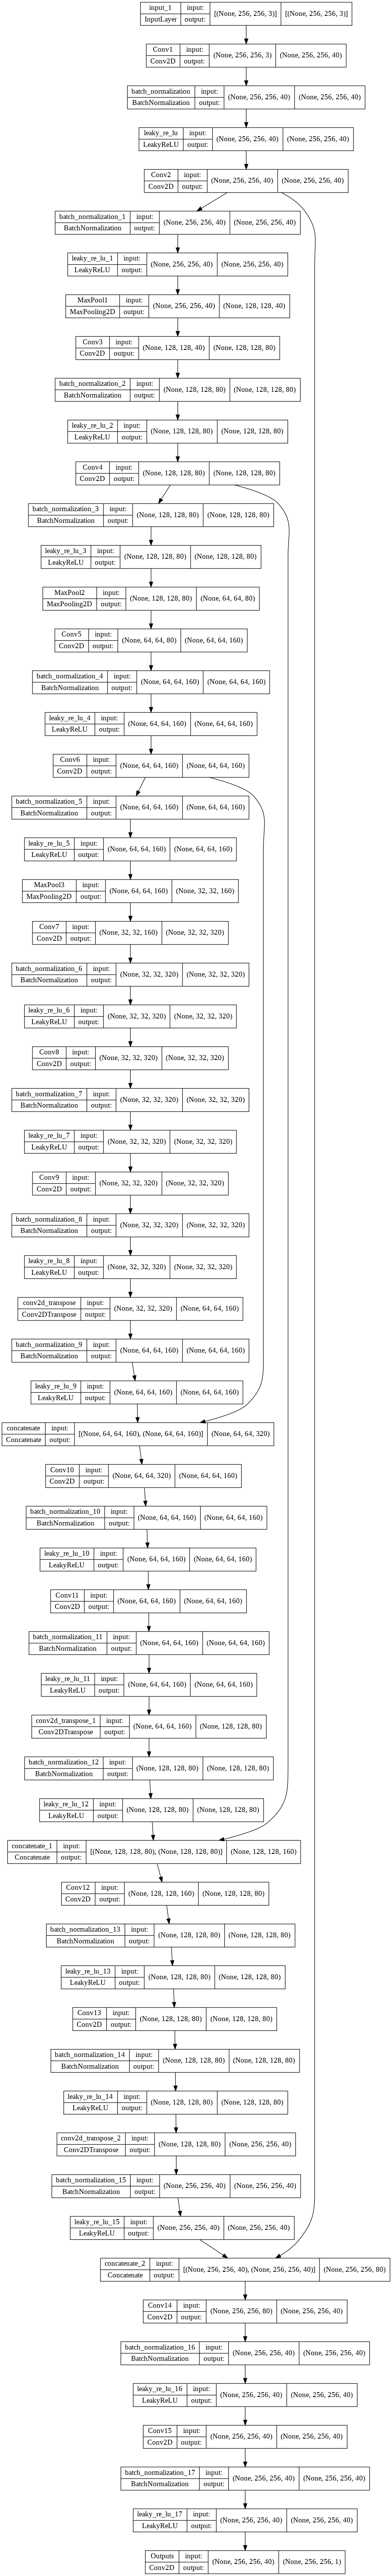

In [ ]:
img_file = './model_arch.png'
tf.keras.utils.plot_model(mymodel, to_file=img_file, show_shapes=True, show_layer_names=True)

### MODEL TRAINING

In [ ]:
x_data1, x_data2, y_data1, y_data2 = train_test_split(input_all,mask_all,
                                                        test_size = 0.5, 
                                                        random_state = 2022)

In [ ]:
x_data1, x_data2, y_data1, y_data2 = train_test_split(input,mask, 
                                                        test_size = 0.5, 
                                                        random_state = 2022)

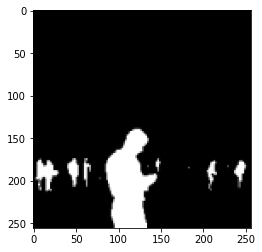

In [ ]:
plt.imshow(y_data1[0])

In [ ]:
saveDataset("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/aug_input",x_data1,"image",0)
saveDataset("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/aug_input_1",x_data2,"image",0)
saveDataset("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/aug_mask",y_data1,"mask",0)
saveDataset("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/aug_mask_1",y_data2,"mask",0)

100%|██████████| 4390/4390 [00:33<00:00, 130.21it/s]


In [ ]:
del x_data2,y_data2

In [ ]:
len(os.listdir("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/input"))

4390

In [ ]:
input_1 = load_images_from_folder("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/aug_input_1")
mask_1 = load_images_from_folder("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/aug_mask_1")

100%|██████████| 4390/4390 [00:26<00:00, 168.83it/s]


In [ ]:
input_extra = load_images_from_folder("/content/drive/MyDrive/penfuddataset/resized_images")
mask_extra = load_images_from_folder("/content/drive/MyDrive/penfuddataset/resized_masks")

100%|██████████| 340/340 [00:02<00:00, 162.53it/s]


In [ ]:
saveDataset("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/input",input_1,"image",0)
saveDataset("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/mask",mask_1,"mask",0)

NameError: ignored

In [ ]:
for i in range(0,len(input_extra)):
    input_extra[i] = cv2.cvtColor(input_extra[i], cv2.COLOR_BGR2RGB)
    mask_extra[i] = cv2.cvtColor(mask_extra[i], cv2.COLOR_RGB2GRAY)
    input_extra[i] = cv2.resize(input_extra[i], (256, 256),interpolation = cv2.INTER_AREA)
    mask_extra[i] = cv2.resize(mask_extra[i], (256, 256),interpolation = cv2.INTER_AREA)

In [ ]:
for i in range(0,len(input_1)):
  #img_dataset[i] = cv2.resize(img_dataset[i], (256, 256),interpolation = cv2.INTER_AREA)
  #mask[i] = cv2.resize(mask[i], (256, 256),interpolation = cv2.INTER_AREA)
  input_1[i] = cv2.cvtColor(input_1[i], cv2.COLOR_BGR2RGB)
  mask_1[i] = cv2.cvtColor(mask_1[i], cv2.COLOR_RGB2GRAY)

In [ ]:
input=input_1+input_extra
mask=mask_1+mask_extra

In [ ]:
del mask_1,input_1,input_extra,mask_extra

In [ ]:
plt.imshow(mask[4700])

In [ ]:
input[0].shape

In [ ]:
input = np.array(input).reshape(len(input),256,256,3)
mask = np.array(mask).reshape(len(mask),256,256)

In [ ]:
input[0].dtype

In [ ]:
len(input)

In [ ]:
x_train_del, x_val_del, y_train_del, y_val_del = train_test_split((input/255).astype(np.float16),
                                                  (mask>127).astype(np.float16),
                                                  test_size = 0.30,random_state = 2022)



In [ ]:
del input
del mask

In [ ]:
print(len(x_train_del),len(y_train_del))

In [ ]:
print(len(x_val_del),len(y_val_del))

In [ ]:
3311 * 0.9  #silinmesi gereken train x,y eleman sayısı  # yaklaşık %20 olacak

In [ ]:
1419 * 0.8 #silinmesi gereken validation x,y eleman sayısı  # yaklaşık %20 olacak

In [ ]:
len(x_train_1)

363

In [ ]:
x_train_del = x_train_del[363:]
y_train_del = y_train_del[363:]
x_val_del = x_val_del[284:]
y_val_del = y_val_del[284:]


In [ ]:
len(x_val)

1135

x_train = x_train_del[:2648]
y_train = y_train_del[:2648]
x_val = x_val_del[:1135]
y_val = y_val_del[:1135]



In [ ]:
del x_train_del, x_val_del, y_train_del, y_val_del

In [ ]:
del x_train, x_val, y_train, y_val

In [ ]:
y_train_del.shape

(2948, 256, 256)

In [ ]:
y_val.shape

In [ ]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

def callbacks(patience=5):
    checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/augmented_part1_150epoch_training.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)
    reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.6, 
                                   patience=4, 
                                   verbose=1, mode='min', min_delta=0.0001, cooldown=2, min_lr=1e-6)
    early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15)
    callbacks_list=[checkpoint, early , reduceLROnPlat]
    return callbacks_list

In [ ]:
mymodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0004),
                loss=[dice_coef_loss],
                metrics = [dice_coef,tf.metrics.MeanIoU(num_classes = 2),tf.metrics.binary_accuracy]
                )

In [ ]:
mymodel.load_weights("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/pedestrian_4m_training_model_good_predicts.h5")

OSError: ignored

In [ ]:
hist= mymodel.fit(x = x_train_del,
                  y = y_train_del,
                  batch_size = 16,
                  epochs =30,
                  validation_data =(x_val_del,y_val_del),
                  callbacks=callbacks())

Epoch 1/30
185/185 [==============================] - ETA: 0s - loss: -0.7107 - dice_coef: 0.7110 - mean_io_u: 0.7695 - binary_accuracy: 0.9734
Epoch 1: loss improved from inf to -0.71073, saving model to /content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/augmented_part1_150epoch_training.h5
185/185 [==============================] - 266s 1s/step - loss: -0.7107 - dice_coef: 0.7110 - mean_io_u: 0.7695 - binary_accuracy: 0.9734 - val_loss: -0.6495 - val_dice_coef: 0.6495 - val_mean_io_u: 0.7232 - val_binary_accuracy: 0.9646 - lr: 4.0000e-04
Epoch 2/30
185/185 [==============================] - ETA: 0s - loss: -0.7128 - dice_coef: 0.7129 - mean_io_u: 0.7695 - binary_accuracy: 0.9736
Epoch 2: loss improved from -0.71073 to -0.71278, saving model to /content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/augmented_part1_150epoch_training.h5
185/185 [==============================] - 237s 1s/step - loss: -0.7128 - dice_coef: 0.7129 - mean_io_u: 0.7695 - 

dict_keys(['loss', 'dice_coef', 'mean_io_u', 'binary_accuracy', 'val_loss', 'val_dice_coef', 'val_mean_io_u', 'val_binary_accuracy', 'lr'])


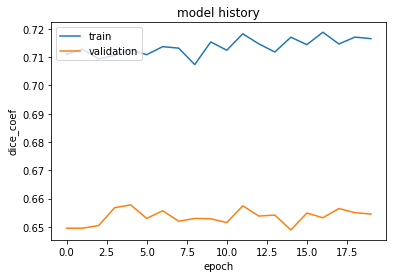

[0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.00024, 0.00024, 0.00024, 0.00024, 0.00024, 0.00014399999, 0.00014399999, 0.00014399999, 0.00014399999, 0.00014399999, 8.6399996e-05]


In [ ]:
#part_1 3. 30 new epoch  
import keras
from matplotlib import pyplot as plt
print(hist.history.keys())
# summarize history for accuracy

# summarize history for loss
plt.plot(hist.history['dice_coef'])
plt.plot(hist.history['val_dice_coef'])
plt.title('model history')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
print(hist.history["lr"])

dict_keys(['loss', 'dice_coef', 'mean_io_u', 'binary_accuracy', 'val_loss', 'val_dice_coef', 'val_mean_io_u', 'val_binary_accuracy', 'lr'])


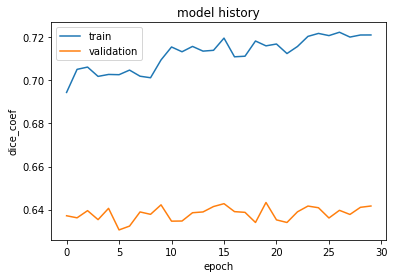

[0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.002, 0.0012, 0.0012, 0.0012, 0.0012, 0.0012, 0.00072, 0.00072, 0.00072, 0.00072, 0.00072, 0.00072, 0.00072, 0.00072, 0.00072, 0.00072, 0.000432, 0.000432, 0.000432, 0.000432, 0.000432, 0.0002592]


In [ ]:
#part_2 2. 30 epoch  
import keras
from matplotlib import pyplot as plt
print(hist.history.keys())
# summarize history for accuracy

# summarize history for loss
plt.plot(hist.history['dice_coef'])
plt.plot(hist.history['val_dice_coef'])
plt.title('model history')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
print(hist.history["lr"])

dict_keys(['loss', 'dice_coef', 'mean_io_u', 'binary_accuracy', 'val_loss', 'val_dice_coef', 'val_mean_io_u', 'val_binary_accuracy', 'lr'])


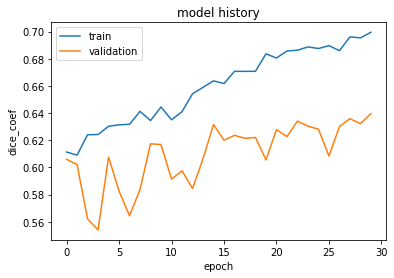

[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.0036, 0.0036, 0.0036, 0.0036, 0.0036, 0.0036, 0.0036, 0.0036, 0.00216, 0.00216, 0.00216]


In [ ]:
#part_2 1. 30 epoch  
import keras
from matplotlib import pyplot as plt
print(hist.history.keys())
# summarize history for accuracy

# summarize history for loss
plt.plot(hist.history['dice_coef'])
plt.plot(hist.history['val_dice_coef'])
plt.title('model history')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
print(hist.history["lr"])

dict_keys(['loss', 'dice_coef', 'mean_io_u', 'binary_accuracy', 'val_loss', 'val_dice_coef', 'val_mean_io_u', 'val_binary_accuracy', 'lr'])


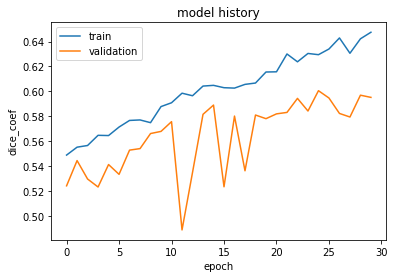

[0.0216, 0.0216, 0.0216, 0.0216, 0.0216, 0.0216, 0.01296, 0.01296, 0.01296, 0.01296, 0.01296, 0.01296, 0.01296, 0.01296, 0.01296, 0.01296, 0.01296, 0.01296, 0.01296, 0.007776, 0.007776, 0.007776, 0.007776, 0.007776, 0.007776, 0.007776, 0.007776, 0.007776, 0.007776, 0.0046656]


In [ ]:
#part_1 2. 30 epoch  
import keras
from matplotlib import pyplot as plt
print(hist.history.keys())
# summarize history for accuracy

# summarize history for loss
plt.plot(hist.history['dice_coef'])
plt.plot(hist.history['val_dice_coef'])
plt.title('model history')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
print(hist.history["lr"])

dict_keys(['loss', 'dice_coef', 'mean_io_u', 'binary_accuracy', 'val_loss', 'val_dice_coef', 'val_mean_io_u', 'val_binary_accuracy', 'lr'])


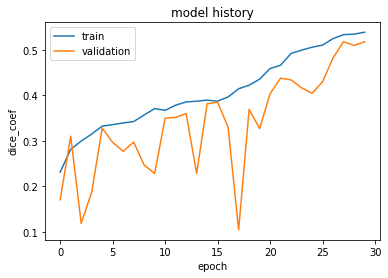

[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.060000002, 0.060000002, 0.060000002, 0.060000002, 0.060000002, 0.060000002, 0.060000002, 0.060000002, 0.060000002, 0.060000002, 0.060000002, 0.036000002, 0.036000002, 0.036000002, 0.036000002, 0.036000002, 0.036000002, 0.0216, 0.0216, 0.0216, 0.0216]


In [ ]:
#part_1_BÜYÜK_LR_İLE 30 epoch  
import keras
from matplotlib import pyplot as plt
print(hist.history.keys())
# summarize history for accuracy

# summarize history for loss
plt.plot(hist.history['dice_coef'])
plt.plot(hist.history['val_dice_coef'])
plt.title('model history')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
print(hist.history["lr"])

dict_keys(['loss', 'dice_coef', 'mean_io_u', 'binary_accuracy', 'val_loss', 'val_dice_coef', 'val_mean_io_u', 'val_binary_accuracy', 'lr'])


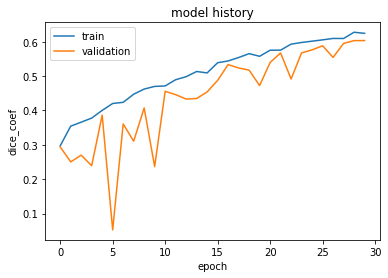

[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006, 0.006]


In [ ]:
#part_1 30 epoch  
import keras
from matplotlib import pyplot as plt
print(hist.history.keys())
# summarize history for accuracy

# summarize history for loss
plt.plot(hist.history['dice_coef'])
plt.plot(hist.history['val_dice_coef'])
plt.title('model history')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
print(hist.history["lr"])

dict_keys(['loss', 'dice_coef', 'mean_io_u', 'binary_accuracy', 'val_loss', 'val_dice_coef', 'val_mean_io_u', 'val_binary_accuracy', 'lr'])


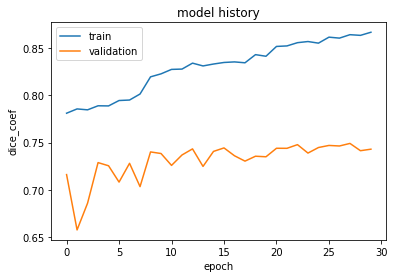

[0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0006, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.00015, 0.00015, 0.00015, 0.00015, 0.00015, 0.00015, 0.00015, 7.5e-05, 7.5e-05, 7.5e-05]


In [ ]:
#NUM 2
import keras
from matplotlib import pyplot as plt
print(hist.history.keys())
# summarize history for accuracy

# summarize history for loss
plt.plot(hist.history['dice_coef'])
plt.plot(hist.history['val_dice_coef'])
plt.title('model history')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
print(hist.history["lr"])

In [ ]:
x_test = cv2.imread("/content/drive/MyDrive/processed_dataset/gamma_crop_dataset/only_person/image2304.png")

In [ ]:
x_test = cv2.resize(x_test, (256, 256),interpolation = cv2.INTER_AREA)
x_test = cv2.cvtColor(x_test, cv2.COLOR_BGR2RGB)
x_test = x_test/255
x_test=np.array(x_test).reshape(1,256,256,3)

In [ ]:
x_test.shape

(1, 256, 256, 3)

In [ ]:
y_pred = mymodel.predict(x_test)

In [ ]:
y_pred = np.array(y_pred).reshape(256,256)

In [ ]:
# from sklearn.metrics import classification_report
# print(classification_report(x_test, y_pred)

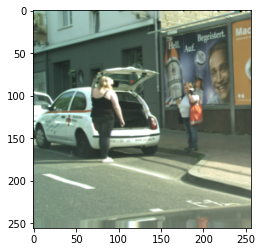

In [ ]:
plt.imshow(x_test[0])


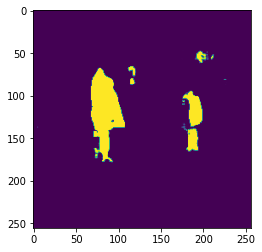

In [ ]:
plt.imshow(y_pred)

In [ ]:
mymodel.

TypeError: ignored

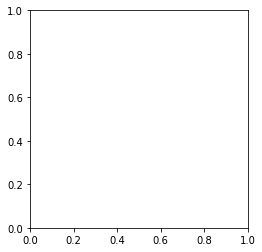

In [ ]:
plt.imshow(y_pred[116])

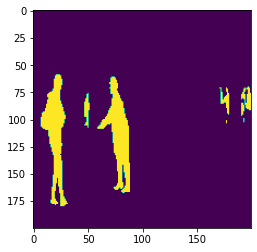

In [ ]:
plt.imshow(y_test[116])

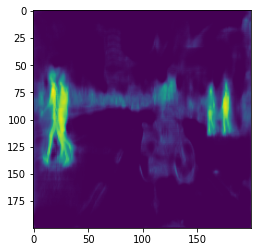

In [ ]:
plt.imshow(y_pred[125])

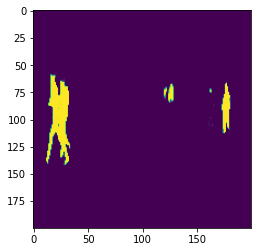

In [ ]:
plt.imshow(y_pred[125])

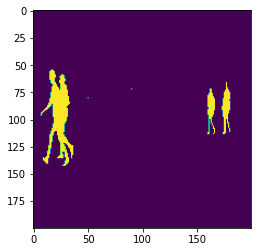

In [ ]:
plt.imshow(y_test[125])

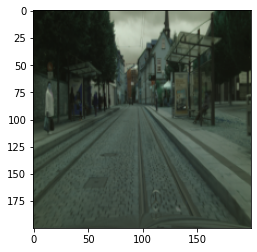

In [ ]:
plt.imshow(x_test[645])